In [ ]:
# Esta celda actúa sobre la libreta, y permite que se aproveche mejor el espacio.
from IPython.core.display import display, HTML
display(HTML("<style>.container{ width:95%}</style>"))
import sys
print(sys.executable) 
#import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import seaborn as sns
from sklearn import preprocessing

from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
El codigo Python de este cuaderno está oculto para facilitar la lectura.
Para mostrar/ocultar el código, haz click <a href="javascript:code_toggle()">aquí.</a>.''')

# Load results

In [ ]:
import pandas as pd
df_alg=pd.read_csv('output/merged_output_genetic.txt')
convert_dict = {'Dataset': "string", 
                'Algorithm': "string",
                'Population Length': "int64",
                'Generations': "int64",
                'Selection Scheme': "string",
                'Selection Candidates': "int64",
                'Crossover Scheme': "string",
                'Crossover Probability': "float64",
                'Mutation Scheme': "string",
                'Mutation Probability': "float64",
                'Replacement Scheme': "string",
                'Time(s)': "float64",
                'AvgValue': "float64",
                'BestAvgValue': "float64",
                'BestGeneration': "int64",
                'HV': "float64",
                'Spread': "float64",
                'NumSolutions': "float64",
                'Spacing': "float64",
                'NumGenerations': "int64"
               } 
df_alg = df_alg.astype(convert_dict) 
df_alg.loc[(df_alg.Dataset == 'dataset1'),'Dataset']='1'
df_alg.loc[(df_alg.Dataset == 'dataset2'),'Dataset']='2'
display(df_alg.head(2))

df_alg2=pd.read_csv('output/merged_output_grasp.txt')
convert_dict = {'Dataset': "string", 
                'Algorithm': "string",
                'Iterations': "int64",
                'Solutions per Iteration': "int64",
                'Local Search Type': "string",
                'Time(s)': "float64",
                'AvgValue': "float64",
                'BestAvgValue': "float64",
                'HV': "float64",
                'Spread': "float64",
                'NumSolutions': "int64",
                'Spacing': "float64",
                'NumGenerations': "int64"
               } 
df_alg2 = df_alg2.astype(convert_dict)
display(df_alg2.head(2))

df_alg = df_alg.append(df_alg2)
display(df_alg.head(2))

---
# Helper functions

## Find configurations in a dataframe

In [ ]:
def findConfigurationDataGenetic(df,algorithm):
    return df[(df["Population Length"]==algorithm.p)&(df["Generations"]==algorithm.g)
                     &(df["Selection Scheme"]==algorithm.ss)&(df["Selection Candidates"]==algorithm.sc)
                     &(df["Crossover Scheme"]==algorithm.cs)&(df["Crossover Probability"]==algorithm.cp)
                     &(df["Mutation Scheme"]==algorithm.ms)&(df["Mutation Probability"]==algorithm.mp)
              &(df["Algorithm"]==algorithm.a)&(df["Replacement Scheme"]==algorithm.rs)
              &(df["Dataset"]==algorithm.d)
             ]
def findConfigurationDataGrasp(df,algorithm):
    return df[(df["Iterations"]==algorithm.it)&(df["Solutions per Iteration"]==algorithm.so)
              &(df["Local Search Type"]==algorithm.ls)
              &(df["Algorithm"]==algorithm.a)&(df["Dataset"]==algorithm.d)
             ]

## Algorithm config structure

In [ ]:
from sklearn import preprocessing
import plotly.graph_objects as go
import plotly.offline as pyo
import math
class AlgorithmDataGenetic():
    def __init__(self,a,rs,d,p,g,ss,sc,cs,cp,ms,mp):
        self.a=a
        self.rs=rs
        self.d=d
        self.p=p
        self.g=g
        self.ss=ss
        self.sc=sc
        self.cs=cs
        self.cp=cp
        self.ms=ms
        self.mp=mp
    
    def findConfigurationData(self,df):
        return df[(df["Population Length"]==self.p)&(df["Generations"]==self.g)
                     &(df["Selection Scheme"]==self.ss)&(df["Selection Candidates"]==self.sc)
                     &(df["Crossover Scheme"]==self.cs)&(df["Crossover Probability"]==self.cp)
                     &(df["Mutation Scheme"]==self.ms)&(df["Mutation Probability"]==self.mp)
              &(df["Algorithm"]==self.a)&(df["Replacement Scheme"]==self.rs)
              &(df["Dataset"]==self.d)
             ]
        
class AlgorithmDataGrasp():
    def __init__(self,a,d,it,so,ls):
        self.a=a
        self.it=it
        self.so=so
        self.ls=ls
        self.d=d
        
    def findConfigurationData(self,df):
        return df[(df["Iterations"]==self.it)&(df["Solutions per Iteration"]==self.so)
              &(df["Local Search Type"]==self.ls)
              &(df["Algorithm"]==self.a)&(df["Dataset"]==self.d)
             ]

## Calculate star chart given an array of configurations and a dataset

In [ ]:
import seaborn as sns

def calculateStarChart(algorithms_array,dataset,time_limit,title,onlyResult=False,fileName="fig1.svg",legend=True):
    #algorithm, replacement,dataset,p,g,ss,sc,cs,cp,ms,mp
    df_radar = df_alg.copy(deep=True)
    df_chartdata=pd.DataFrame(columns=df_radar.columns)
    for algorithm in algorithms_array:
        df_star_d1_gnds=algorithm.findConfigurationData(df_radar)
        print("Datos configuracion") if not onlyResult else 0
        display(df_star_d1_gnds.head(5)) if not onlyResult else 0
        df_chartdata=df_chartdata.append(df_star_d1_gnds)
        
    display(df_chartdata.head(5)) if not onlyResult else 0
    
    scaler = preprocessing.MinMaxScaler()
    
    df_radar=df_radar[(df_radar['Dataset']==dataset)&(df_radar['Time(s)']<time_limit)]
                
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(x=df_radar["Time(s)"])
    
    df_radar['Time(s)']=1/df_radar['Time(s)']
    df_radar['Spread']=1/df_radar['Spread']
    
    df_radar['HV'] = scaler.fit_transform(df_radar[['HV']].values.astype(float))
    df_radar['Spread'] = scaler.fit_transform(df_radar[['Spread']].values.astype(float))
    df_radar['Spacing'] = scaler.fit_transform(df_radar[['Spacing']].values.astype(float))
    df_radar['NumSolutions'] = scaler.fit_transform(df_radar[['NumSolutions']].values.astype(float))
    df_radar['AvgValue'] = scaler.fit_transform(df_radar[['AvgValue']].values.astype(float))
    df_radar['Time(s)'] = scaler.fit_transform(df_radar[['Time(s)']].values.astype(float))
    
    print("Datos normalizados") if not onlyResult else 0
    display(df_radar[df_radar["Algorithm"]=="GRASP"]) if not onlyResult else 0

    
    # dibujar grafico
    categories = ['AvgValue', 'NºSols', 'Spacing', '1/Spread','HV']
    categories = [*categories, categories[0]]

    data=[]
    titles=[]
    for algorithm in algorithms_array:
        df_aux=algorithm.findConfigurationData(df_radar)
        display(df_aux)
        df_aux_means=df_aux[['AvgValue','Spread', 'Spacing', 'NumSolutions','HV',]].mean()
        print("means") if not onlyResult else 0
        display(df_aux_means) if not onlyResult else 0
        aux_data = list(df_aux_means) 
        aux_data = [*aux_data, aux_data[0]]
        data.append(aux_data)
        titles.append( (algorithm.a#+"-"+algorithm.rs
                       ) )
        print(aux_data)
    markers=["circle","square","diamond", "square"]
    dashes=["solid","dot","dash","solid"]
    titles=["GeneticNDS elitism","GeneticNDS elitismNDS","NSGA-II","GRASP"]
    fig = go.Figure(
        data=[
            go.Scatterpolar(r=data[x],marker_symbol=markers[x] ,theta=categories, name=titles[x],line_dash=dashes[x]) for x in range(0,len(data))
        ],
        layout=go.Layout(
            polar={'radialaxis': {'visible': True,'showticklabels':False,'range':[0, 1],'showline':False},
                   'angularaxis':{'rotation':90,},
                  },
            showlegend=legend
        )
    )
    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        xanchor="center",
        x=0.5
    ))
    pyo.plot(fig)
    fig.write_image(fileName)

In [ ]:
#prueba
algorithm1=AlgorithmDataGenetic("GeneticNDSAlgorithm",'elitism',"1",20,100,"tournament",2,"onepoint",0.9,"flip1bit",0.05)
algorithm2=AlgorithmDataGenetic("GeneticNDSAlgorithm",'elitismnds',"1",20,100,"tournament",2,"onepoint",0.9,"flip1bit",0.05)
algorithm3=AlgorithmDataGenetic("NSGAIIAlgorithm",'elitism',"1",20,100,"tournament",2,"onepoint",0.9,"flip1bit",0.05)
algorithm4=AlgorithmDataGrasp("GRASP","1",20,20,"best_first_neighbor")
df_radar = df_alg.copy(deep=True)
df_radar2 = df_alg2.copy(deep=True)
df_radar = df_radar.append(df_radar2)
display(algorithm4.findConfigurationData(df_radar)[['AvgValue','Spread', 'Spacing', 'NumSolutions','HV',]].mean())
calculateStarChart([algorithm1,algorithm2,algorithm3,algorithm4],"1",120,"title",onlyResult=False)

---
# Best configs for Dataset 1

## Best config for GeneticNDS elitism

In [ ]:
algs=[]
dfs=[]
configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="GeneticNDSAlgorithm")&(df_alg["Dataset"]=="1")&(df_alg["Replacement Scheme"]=="elitism")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
dfs.append(df_a.to_numpy()[0])
display(df_a)
alg=AlgorithmDataGenetic("GeneticNDSAlgorithm",'elitism',"1",40,200,"tournament",2,"onepoint",0.85,"flip1bit",0.1)
algs.append(alg)
display(alg.findConfigurationData(df_alg))

## Best config for GeneticNDS elitismNDS

In [ ]:
configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="GeneticNDSAlgorithm")&(df_alg["Dataset"]=="1")&(df_alg["Replacement Scheme"]=="elitismnds")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
dfs.append(df_a.to_numpy()[0])
display(df_a)
alg=AlgorithmDataGenetic("GeneticNDSAlgorithm",'elitismnds',"1",30,200,"tournament",2,"onepoint",0.9,"flip1bit",0.1)
algs.append(alg)
display(alg.findConfigurationData(df_alg))

## Best config for NSGA-II elitism

In [ ]:
configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="NSGAIIAlgorithm")&(df_alg["Dataset"]=="1")&(df_alg["Replacement Scheme"]=="elitism")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
dfs.append(df_a.to_numpy()[0])
display(df_a)
alg=AlgorithmDataGenetic("NSGAIIAlgorithm",'elitism',"1",40,300,"tournament",2,"onepoint",0.85,"flip1bit",1)
algs.append(alg)
display(alg.findConfigurationData(df_alg))

## Best config for GRASP

In [ ]:
configs=["Algorithm","Iterations","Solutions per Iteration"]

df_a = df_alg[(df_alg["Algorithm"]=="GRASP")&(df_alg["Dataset"]=="1")&(df_alg["Local Search Type"]=="best_first_neighbor")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","NumSolutions","Spacing","NumGenerations"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
dfs.append(df_a.to_numpy()[0])
display(df_a)
alg=AlgorithmDataGrasp("GRASP","1",20,20,"best_first_neighbor")
algs.append(alg)
display(alg.findConfigurationData(df_alg))

## Wilcoxon Test

In [ ]:
from scipy.stats import ranksums

cols=["AvgValue","HV","Spread","Spacing","NumSolutions","BestGeneration"]

results=list()
best_avg=0
best_alg_index=None
#results.append("Métrica AvgValue")
for i in range(len(algs)):
    avg=np.mean((algs[i].findConfigurationData(df_alg)[cols])["AvgValue"].values)
    results.append("{:.3f}".format(avg))
    if avg>best_avg:
        best_avg=avg
        best_alg_index=i

p_best=True
for i in range(len(algs)):
    if i!=best_alg_index:
        dataA=(algs[best_alg_index].findConfigurationData(df_alg)[cols])["AvgValue"].values
        dataB=(algs[i].findConfigurationData(df_alg)[cols])["AvgValue"].values
        _, p = ranksums(dataA, dataB)
        print(p)
        if p>=0.05:
            p_best=False
        
if p_best:
    mark = '*'
else:
    mark = ''
results[best_alg_index]=results[best_alg_index]+mark
results.insert(0,"AvgValue")
print(results)
    

In [ ]:
cols=["AvgValue","HV","Spread","Spacing","NumSolutions","BestGeneration","Time(s)"]
maxmin=[1,1,-1,1,1,1,-1]

for j in range(len(cols)): 
    print(cols[j])
    results=list()
    best_avg=0
    best_avgn=10**9
    best_alg_index=None
    for i in range(len(algs)):
        avg=np.mean((algs[i].findConfigurationData(df_alg)[cols])[cols[j]].values)
        results.append("{:.3f}".format(avg))
        if maxmin[j]>0 and avg>best_avg:
            best_avg=avg
            best_alg_index=i
        elif maxmin[j]<0 and avg<best_avgn:
            best_avgn=avg
            best_alg_index=i

    p_best=True
    p_list=[]
    for i in range(len(algs)):
        if i!=best_alg_index:
            dataA=(algs[best_alg_index].findConfigurationData(df_alg)[cols])[cols[j]].values
            dataB=(algs[i].findConfigurationData(df_alg)[cols])[cols[j]].values
            _, p = ranksums(dataA, dataB)
            print("p:",p)
            if p>=0.05:
                #print(dataA)
                #print(dataB)
                p_best=False
            else:
                p_list.append(i)

    if p_best:
        mark = '*'
    else:
        mark = ''
    for index in p_list:
        results[index]=results[index]+'-'
    #results[best_alg_index]=results[best_alg_index]+mark
    results.insert(0,cols[j])
    print(results)
    

## Generate Star Chart

In [ ]:
time_limit=2*60
calculateStarChart(algs,"1",time_limit,"Dataset 1",onlyResult=True,fileName="plots/dataset1_star.svg")

---
# Dataset 2

## Best config for GeneticNDS elitism

In [ ]:
algs2=[]

configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="GeneticNDSAlgorithm")&(df_alg["Dataset"]=="2")&(df_alg["Replacement Scheme"]=="elitism")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
display(df_a)
alg=AlgorithmDataGenetic("GeneticNDSAlgorithm",'elitism',"2",20,200,"tournament",2,"onepoint",0.9,"flip1bit",0.7)
algs2.append(alg)
display(alg.findConfigurationData(df_alg))

## Best config for GeneticNDS elitismNDS

In [ ]:
configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="GeneticNDSAlgorithm")&(df_alg["Dataset"]=="2")&(df_alg["Replacement Scheme"]=="elitismnds")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
display(df_a)
alg=AlgorithmDataGenetic("GeneticNDSAlgorithm",'elitismnds',"2",20,100,"tournament",2,"onepoint",0.6,"flip1bit",0.7)
algs2.append(alg)
display(alg.findConfigurationData(df_alg))

## Best config for NSGA-II elitism

In [ ]:
configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="NSGAIIAlgorithm")&(df_alg["Dataset"]=="2")&(df_alg["Replacement Scheme"]=="elitism")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
display(df_a)
alg=AlgorithmDataGenetic("NSGAIIAlgorithm",'elitism',"2",30,200,"tournament",2,"onepoint",0.6,"flipeachbit",0.05)
algs2.append(alg)
display(alg.findConfigurationData(df_alg))

## Best config for GRASP

In [ ]:
configs=["Algorithm","Iterations","Solutions per Iteration"]

df_a = df_alg[(df_alg["Algorithm"]=="GRASP")&(df_alg["Dataset"]=="2")&(df_alg["Local Search Type"]=="best_first_neighbor")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","NumSolutions","Spacing","NumGenerations"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
display(df_a)
alg=AlgorithmDataGrasp("GRASP","2",300,100,"best_first_neighbor")
algs2.append(alg)
display(alg.findConfigurationData(df_alg))

## Generate Star Chart

In [ ]:
calculateStarChart(algs2,"2",time_limit,"Dataset 2",onlyResult=True,fileName="plots/dataset2_star.svg")

## Wilcoxon Test

In [ ]:
cols=["AvgValue","HV","Spread","Spacing","NumSolutions","BestGeneration","Time(s)"]
maxmin=[1,1,-1,1,1,1,-1]

for j in range(len(cols)): 
    print(cols[j])
    results=list()
    best_avg=0
    best_avgn=10**9
    best_alg_index=None
    for i in range(len(algs2)):
        avg=np.mean((findConfigurationData(df_alg,algs2[i])[cols])[cols[j]].values)
        results.append("{:.3f}".format(avg))
        if maxmin[j]>0 and avg>best_avg:
            best_avg=avg
            best_alg_index=i
        elif maxmin[j]<0 and avg<best_avgn:
            best_avgn=avg
            best_alg_index=i

    p_best=True
    p_list=[]
    for i in range(len(algs2)):
        if i!=best_alg_index:
            dataA=(findConfigurationData(df_alg,algs2[best_alg_index])[cols])[cols[j]].values
            dataB=(findConfigurationData(df_alg,algs2[i])[cols])[cols[j]].values
            _, p = ranksums(dataA, dataB)
            print("p:",p)
            if p>=0.05:
                #print(dataA)
                #print(dataB)
                p_best=False
            else:
                p_list.append(i)

    if p_best:
        mark = '*'
    else:
        mark = ''
    for index in p_list:
        results[index]=results[index]+'-'
    #results[best_alg_index]=results[best_alg_index]+mark
    results.insert(0,cols[j])
    print(results)
    

## Generate Dataset 1 Pareto comparison

Running...

NDS created has 37 solution(s)


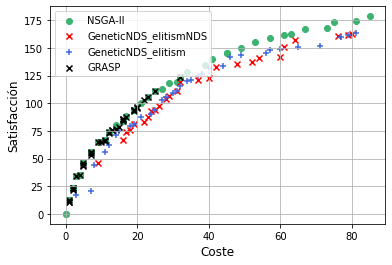

<Figure size 432x288 with 0 Axes>

In [3]:
from algorithms.genetic.genetic_algorithm import GeneticAlgorithm
from algorithms.nsgaii.nsgaii_algorithm import NSGAIIAlgorithm
from algorithms.GRASP.GRASP import GRASP
from datasets.dataset1 import generate_dataset1_genes
from algorithms.geneticnds.geneticnds_algorithm import GeneticNDSAlgorithm
from datasets.dataset2 import generate_dataset2_genes
from models.problem import Problem
import matplotlib.pyplot as plt
import pandas as pd
# crear seed random------------------------------------------------------------------
seed=54

# iniciar------------------------------------------------------------------
print("Running...")

algorithm=NSGAIIAlgorithm(dataset_name="1",random_seed=seed,population_length=40,max_generations=300,crossover_prob=0.85,
						   crossover="onepoint",mutation_prob=1,mutation="flip1bit",replacement="elitism")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function1 = [i[0].value for i in func]
function2 = [i[1].value for i in func]

algorithm=GeneticNDSAlgorithm(dataset_name="1",random_seed=seed,population_length=30,max_generations=200,crossover_prob=0.9,
							 crossover="onepoint", mutation_prob=0.1,mutation="flip1bit",replacement="elitismnds")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function3 = [i[0].value for i in func]
function4 = [i[1].value for i in func]


algorithm=GeneticNDSAlgorithm(dataset_name="1",random_seed=seed,population_length=40,max_generations=200,crossover_prob=0.85,
							  crossover="onepoint", mutation_prob=0.1,mutation="flip1bit",replacement="elitism")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function5 = [i[0].value for i in func]
function6 = [i[1].value for i in func]

algorithm=GRASP(dataset="1",iterations=20,solutions_per_iteration=20,local_search_type="best_first_neighbor")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function7 = [i[0].value for i in func]
function8 = [i[1].value for i in func]

plt.xlabel('Coste', fontsize=12)
plt.ylabel('Satisfacción', fontsize=12)
plt.scatter(function2, function1, marker='o',label="NSGA-II",c="#3cb371")
plt.scatter(function4, function3, marker='x',label="GeneticNDS_elitismNDS",c="#ff0000")
plt.scatter(function6, function5, marker='+',label="GeneticNDS_elitism",c="#4169e1")
plt.scatter(function8, function7, marker='x',label="GRASP",c="#000000")
plt.legend(loc="upper left")
fig1 = plt.gcf()
plt.grid(True)
plt.show()
plt.draw()
fig1.savefig('plots/dataset1_pareto.svg', dpi=100)

## Generate Dataset 2 Pareto comparison

Running...

NDS created has 460 solution(s)


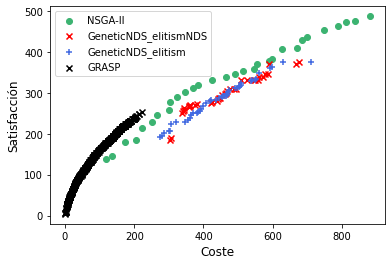

<Figure size 432x288 with 0 Axes>

In [2]:
from algorithms.genetic.genetic_algorithm import GeneticAlgorithm
from algorithms.nsgaii.nsgaii_algorithm import NSGAIIAlgorithm
from algorithms.geneticnds.geneticnds_algorithm import GeneticNDSAlgorithm
from algorithms.GRASP.GRASP import GRASP
from datasets.dataset2 import generate_dataset2_genes
from models.problem import Problem
import matplotlib.pyplot as plt
import pandas as pd
# crear seed random------------------------------------------------------------------
seed=54

# iniciar------------------------------------------------------------------
print("Running...")

algorithm=NSGAIIAlgorithm(dataset_name="2",random_seed=seed,population_length=30,max_generations=200,crossover_prob=0.6,
						   crossover="onepoint",mutation_prob=0.05,mutation="flipeachbit",replacement="elitism")
result=algorithm.run()

func = [i.objectives for i in result["population"]]
function1 = [i[0].value for i in func]
function2 = [i[1].value for i in func]

algorithm=GeneticNDSAlgorithm(dataset_name="2",random_seed=seed,population_length=20,max_generations=100,crossover_prob=0.6,
							 crossover="onepoint", mutation_prob=0.7,mutation="flip1bit",replacement="elitismnds")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function3 = [i[0].value for i in func]
function4 = [i[1].value for i in func]


algorithm=GeneticNDSAlgorithm(dataset_name="2",random_seed=seed,population_length=20,max_generations=200,crossover_prob=0.9,
							  crossover="onepoint", mutation_prob=0.7,mutation="flip1bit",replacement="elitism")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function5 = [i[0].value for i in func]
function6 = [i[1].value for i in func]

algorithm=GRASP(dataset="2",iterations=300,solutions_per_iteration=100,local_search_type="best_first_neighbor")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function7 = [i[0].value for i in func]
function8 = [i[1].value for i in func]

plt.xlabel('Coste', fontsize=12)
plt.ylabel('Satisfacción', fontsize=12)
plt.scatter(function2, function1, marker='o',label="NSGA-II",c="#3cb371")
plt.scatter(function4, function3, marker='x',label="GeneticNDS_elitismNDS",c="#ff0000")
plt.scatter(function6, function5, marker='+',label="GeneticNDS_elitism",c="#4169e1")
plt.scatter(function8, function7, marker='x',label="GRASP",c="#000000")
plt.legend(loc="upper left")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('plots/dataset2_pareto.svg', dpi=100)

Running...

NDS created has 423 solution(s)
242.2 206
11.6 2
253.20000000000002 223
225.00000000000003 182
235.60000000000002 194
236.2 199
219.00000000000003 173
229.60000000000002 185
86.8 35
68.60000000000001 25
5.8 1
224.60000000000002 180
9.8 2
183.40000000000003 128
230.60000000000002 189
15.6 3
230.00000000000003 187
247.4 214
231.20000000000002 191
153.60000000000002 93
206.00000000000003 154
205.80000000000004 154
154.4 95
189.00000000000003 135
236.6 199
101.80000000000001 47
23.400000000000002 6
148.60000000000002 88
99.8 44
52.4 17
248.0 215
229.00000000000003 184
28.8 8
205.40000000000003 152
136.4 76
70.4 25
4.0 1
159.20000000000002 99
142.60000000000002 82
205.60000000000005 153
223.00000000000003 175
48.400000000000006 16
5.8 1
83.4 34
142.4 82
52.6 17
115.2 57
18.0 4
121.80000000000001 63
158.00000000000003 96
218.00000000000003 171
159.0 98
237.2 201
212.40000000000003 163
102.00000000000001 48
102.4 48
230.60000000000002 189
235.60000000000002 196
205.80000000000004 

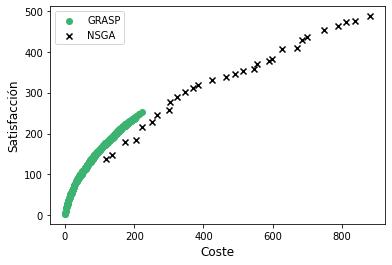

<Figure size 432x288 with 0 Axes>

In [5]:
from algorithms.genetic.genetic_algorithm import GeneticAlgorithm
from algorithms.nsgaii.nsgaii_algorithm import NSGAIIAlgorithm
from algorithms.geneticnds.geneticnds_algorithm import GeneticNDSAlgorithm
from algorithms.GRASP.GRASP import GRASP
from datasets.dataset1 import generate_dataset1_genes
from datasets.dataset2 import generate_dataset2_genes

from models.problem import Problem
import matplotlib.pyplot as plt
import pandas as pd
# crear seed random------------------------------------------------------------------
seed=54

# iniciar------------------------------------------------------------------
print("Running...")

algorithm=GRASP(dataset="2",iterations=300,solutions_per_iteration=100,local_search_type="best_first_neighbor")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function1 = [i[0].value for i in func]
function2 = [i[1].value for i in func]

for i in func:
    print(i[0].value,i[1].value)
    
algorithm=NSGAIIAlgorithm(dataset_name="2",random_seed=seed,population_length=30,max_generations=200,crossover_prob=0.6,
						   crossover="onepoint",mutation_prob=0.05,mutation="flipeachbit",replacement="elitism")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function3 = [i[0].value for i in func]
function4 = [i[1].value for i in func]

plt.xlabel('Coste', fontsize=12)
plt.ylabel('Satisfacción', fontsize=12)
plt.scatter(function2, function1, marker='o',label="GRASP",c="#3cb371")
plt.scatter(function4, function3, marker='x',label="NSGA",c="#000000")
plt.legend(loc="upper left")
fig1 = plt.gcf()
plt.show()
plt.draw()